In [66]:
import numpy as np
import torch
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix
from torch.utils.data import TensorDataset, DataLoader
from gensim.models import Word2Vec

In [63]:
!pip install gensim --user

  Obtaining dependency information for FuzzyTM>=0.4.0 from https://files.pythonhosted.org/packages/2d/30/074bac7a25866a2807c1005c7852c0139ac22ba837871fc01f16df29b9dc/FuzzyTM-2.0.9-py3-none-any.whl.metadata
  Using cached FuzzyTM-2.0.9-py3-none-any.whl.metadata (7.9 kB)
  Obtaining dependency information for pyfume from https://files.pythonhosted.org/packages/ed/ea/a3b120e251145dcdb10777f2bc5f18b1496fd999d705a178c1b0ad947ce1/pyFUME-0.3.4-py3-none-any.whl.metadata
  Using cached pyFUME-0.3.4-py3-none-any.whl.metadata (9.7 kB)
  Obtaining dependency information for scipy>=1.7.0 from https://files.pythonhosted.org/packages/65/76/903324159e4a3566e518c558aeb21571d642f781d842d8dd0fd9c6b0645a/scipy-1.10.1-cp311-cp311-win_amd64.whl.metadata
  Using cached scipy-1.10.1-cp311-cp311-win_amd64.whl.metadata (58 kB)
  Obtaining dependency information for simpful==2.12.0 from https://files.pythonhosted.org/packages/9d/0e/aebc2fb0b0f481994179b2ee2b8e6bbf0894d971594688c018375e7076ea/simpful-2.12.0-py3-n

text: a string feature representing the tweet.
label: a classification label with the following values:
0: sadness
1: joy
2: love
3: anger
4: fear
5: surprise

In [3]:
# Read the Parquet file
file_path = "train-00000-of-00001.parquet"  # Replace with your Parquet file path
df = pd.read_parquet(file_path)

# Inspect the DataFrame
df

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2
...,...,...
416804,that was what i felt when i was finally accept...,1
416805,i take every day as it comes i m just focussin...,4
416806,i just suddenly feel that everything was fake,0
416807,im feeling more eager than ever to claw back w...,1


# Data Exploration

In [4]:
# Count samples for each label
label_counts = df['label'].value_counts()
print("Number of samples per label:")
print(label_counts)

Number of samples per label:
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: label, dtype: int64


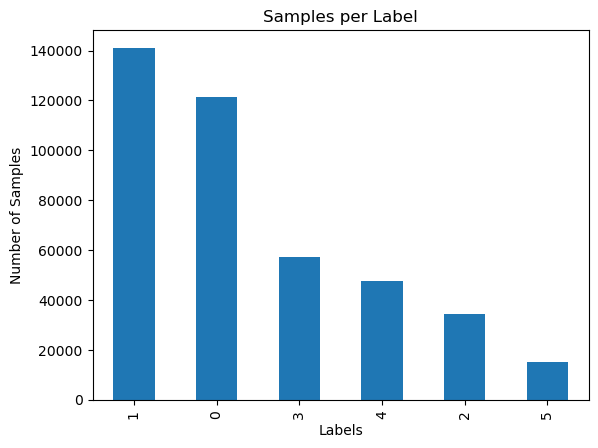

In [5]:
label_counts.plot(kind='bar')
plt.title("Samples per Label")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

In [6]:
# Determine the minority class size
minority_class_size = label_counts.min()
print(f"Minority class size: {minority_class_size}")

Minority class size: 14972


In [7]:
# Group by the category and sample the minority class size for each group
balanced_df = (
    df.groupby('label')
    .apply(lambda x: x.sample(n=minority_class_size, random_state=42))  # Randomly select samples
    .reset_index(drop=True)  # Reset the index
)

print("Class distribution after undersampling:")
print(balanced_df['label'].value_counts())

Class distribution after undersampling:
0    14972
1    14972
2    14972
3    14972
4    14972
5    14972
Name: label, dtype: int64


In [8]:
balanced_df

,text,label
0,i feel sorry about you because your point of v...,0
1,i feel like he s watching quietly because he s...,0
2,i feel im ugly ugly ugly and ugly now,0
3,i remember my shower and the drawn out manner ...,0
4,i feel unwelcome when we can t go inside right...,0
...,...,...
89827,i feel amazing posted on a href http www,5
89828,i gotta feeling and oprah was not only shocked...,5
89829,i feel amazed as i watch these photos and foot...,5
89830,i am asked early in the morning through an int...,5


In [9]:
# Set pandas to display full text in columns
pd.set_option('display.max_colwidth', None)

balanced_df[balanced_df.label == 0]

,text,label
0,i feel sorry about you because your point of view is indoctrinated by these left wing european historical revisionists textbooks,0
1,i feel like he s watching quietly because he s resigned he s come to realize that people are going to die and there s nothing he can do about it,0
2,i feel im ugly ugly ugly and ugly now,0
3,i remember my shower and the drawn out manner in which i pressed my body up against the wall feeling a listless desperation in feigning the inability to support myself,0
4,i feel unwelcome when we can t go inside right away it hurts my feelings,0
...,...,...
14967,i was feeling throughly disillusioned with love i am currently still a hopeless hapless romantic img src http s,0
14968,i just need to sink into a hot bath wash the city grime out of my hair and skin and hope that the feeling returns to my abused legs by tomorrow well the dr did say that gentle exercise is essential for post dvt patients,0
14969,i feel like ive got a real handle on it like its an unpleasant thing that must be dealt with but life is otherwise so good that its more hassle than tragedy,0
14970,i just hate feeling helpless,0


In [10]:
balanced_df[balanced_df.label == 1]

,text,label
14972,i feel pretty talented,1
14973,i mean not much to feel obviously we have to look after ourselves and as i said i m very happy,1
14974,i feel excited and honored to have been given this opportunity by pulkit and ila,1
14975,to have a friend who i didnt see for months,1
14976,i was feeling stronger and fantastic,1
...,...,...
29939,i still wasn t feeling very sociable by the beginning of the week so remained a bit quiet and decided not to attend the skeptics in the pub debate on monday night,1
29940,i go i feel like i learn something very valuable and i also feel so much better in my body,1
29941,i feel contented and motivated to live like him,1
29942,i cant wait to stroll down the beach feeling comfortable with my body,1


In [11]:
balanced_df[balanced_df.label == 2]

,text,label
29944,i swore i could feel the cherishment in every gentle stroke,2
29945,i feel so devoted to my relationship and to myself which luckily go hand in hand for me,2
29946,i feel that if it was an image of someone doing something that they didnt want others to see such as the work of paul graham beyond caring i can see a reason why you would want something in return as these people are vunerable and run down while dicorcias heads image of mr,2
29947,i hover my pussy above his head just enough for me to feel the heat of his breath on my most tender parts and for him to smell my womanliness,2
29948,i was feeling horny sitting alone in the house,2
...,...,...
44911,i feel a tad more longing for my home my domain,2
44912,i feel the most passionate about for very personal reasons,2
44913,i cant really sleep on my back for long and i fidget around in bed because i feel so freakin hot imma burst into flames,2
44914,i dont think i should feel this way towards the person caring for my son,2


In [12]:
balanced_df[balanced_df.label == 3]

,text,label
44916,i feel irritated and i kinda hate this feeling,3
44917,id rather be home feeling violent and lonely im not trying to sound so insincere but the postcard thats taped to the freezer reads wish you were here how i wish i could disappear heads up,3
44918,i suggest you wait to discuss this with them until you re feeling less resentful,3
44919,i wrong to feel royally pissed off at all this,3
44920,im so tierd of talking about him like theres hope as if hell care to understand what it is i feel nikki tells me hes stubborn and just full of himself but whatever it may be it hurts because i feel so crappy,3
...,...,...
59883,i did notice less oil on my makeup free face at the end of the day though my skin didnt feel irritated or dry,3
59884,i feel cold hearted and maybe i am,3
59885,i feel a little physically irritable right now i decided i needed to share and then by doing so maybe i can take my mind off of how my body is feeling at least for a bit,3
59886,i start feeling annoyed and tired of it,3


In [13]:
balanced_df[balanced_df.label == 4]

,text,label
59888,i also am enjoying d a lot more now that i have gotten to know the majority of the people around me i don t feel pressured to make absolutely perfect work every time and can now just enjoy working and improving at my own pace,4
59889,i feel like i have restless leg syndrome this week,4
59890,i feel as though i am completely paranoid of everyone around me,4
59891,i was actually feeling the nervous nellies when i walked in because of that,4
59892,i feel vulnerable in so many situations but my weight no longer reflects that,4
...,...,...
74855,im fighting with myself it feels sometimes im scared,4
74856,im feeling very doubtful now,4
74857,i was feeling overly anxious and depressed towards the end of the ride monica would pick me up with the hint of i think that i might hear the highway through the trees or this stream looks very familiar,4
74858,i feel afraid or overwhelmed or completely out of my mind i turn to him my son the archer who has always seen his a href http www,4


In [14]:
balanced_df[balanced_df.label == 5]

,text,label
74860,i feel like a weird fish out of water listing to the little drummer boy while shopping for my halloween costume,5
74861,im terribly disappointed and yet i feel ludicrous saying so its a damn good excuse his father is having heart trouble may need repeat surgery,5
74862,i feel like ive entered some weird universe and i really am grateful for it,5
74863,i still want to feel amazed by a thunderstorm i still want to be inspired by the look of tiny droplets of rain on a spiders web i still want to feel the same way i do when a cold drop of rain hits my warm skin,5
74864,i feel impressed to share with that there are voices and vices of the enemy that we must identify and overthrow,5
...,...,...
89827,i feel amazing posted on a href http www,5
89828,i gotta feeling and oprah was not only shocked she was thrilled,5
89829,i feel amazed as i watch these photos and footage of this truly unique organism for i know that it might be the only opportunity so many of us will ever have to see something like it again,5
89830,i am asked early in the morning through an interview what brings me to krakow why and how i feel about my visit my impressions of the place and whether i am surprised that the poles have interest in hindi and hindi cinema,5


In [15]:
pd.reset_option('display.max_colwidth')

In [16]:
# Function to calculate word count
balanced_df['word_count'] = balanced_df['text'].apply(lambda x: len(str(x).split()))
balanced_df

,text,label,word_count
0,i feel sorry about you because your point of v...,0,20
1,i feel like he s watching quietly because he s...,0,31
2,i feel im ugly ugly ugly and ugly now,0,9
3,i remember my shower and the drawn out manner ...,0,30
4,i feel unwelcome when we can t go inside right...,0,15
...,...,...,...
89827,i feel amazing posted on a href http www,5,9
89828,i gotta feeling and oprah was not only shocked...,5,12
89829,i feel amazed as i watch these photos and foot...,5,38
89830,i am asked early in the morning through an int...,5,43


In [17]:
# Calculate statistics
min_words = balanced_df['word_count'].min()
max_words = balanced_df['word_count'].max()
avg_words = balanced_df['word_count'].mean()

print(f"Minimum words: {min_words}")
print(f"Maximum words: {max_words}")
print(f"Average words: {avg_words:.2f}")

Minimum words: 1
Maximum words: 100
Average words: 19.44


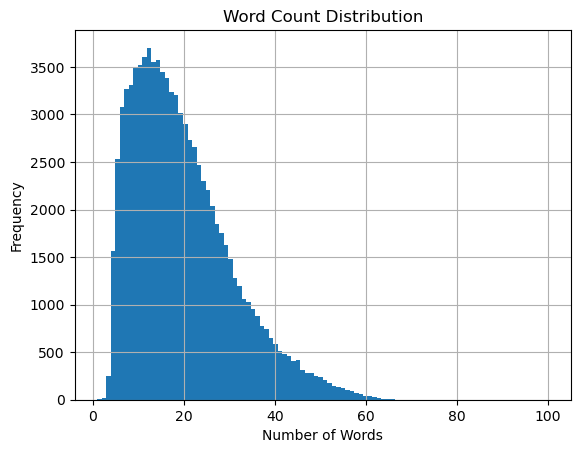

In [18]:
balanced_df['word_count'].hist(bins=100)
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [19]:
# Create Bag of Words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(balanced_df['text'])  # Features
y = balanced_df['label']  # Labels

X

<89832x36275 sparse matrix of type '<class 'numpy.int64'>'
	with 1419944 stored elements in Compressed Sparse Row format>

In [20]:
print(X[74856].shape)
print(X[74856].sum())
## Words of 1 letter are ommitted from the sum?
X[74856].toarray()

(1, 36275)
5


array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [21]:
print(vectorizer.get_feature_names_out()[10:100])  # List (some) of words in the vocabulary

['aaron' 'aarons' 'aarthi' 'aate' 'aatp' 'ab' 'aback' 'abad' 'abandon'
 'abandoned' 'abandoning' 'abandonment' 'abashed' 'abate' 'abaya' 'abba'
 'abbasi' 'abbey' 'abbigail' 'abbott' 'abby' 'abc' 'abcesses' 'abd'
 'abdomen' 'abdominal' 'abduct' 'abducted' 'abdul' 'abe' 'abed' 'abefc'
 'abel' 'abercrombie' 'abhay' 'abhorr' 'abhorred' 'abhorrent' 'abi'
 'abide' 'abides' 'abiding' 'abigail' 'abililty' 'abilities' 'ability'
 'abilty' 'abit' 'abject' 'ablaze' 'able' 'ableness' 'ablity' 'ablo'
 'ably' 'abnormal' 'abnormality' 'abnormally' 'abo' 'aboard' 'abocs'
 'abode' 'abolish' 'abolitionist' 'abominable' 'aboriginal'
 'aboriginality' 'aboriginals' 'aborted' 'abortion' 'abotu' 'abou'
 'abound' 'abounding' 'abour' 'about' 'above' 'abq' 'abraham' 'abrahams'
 'abrams' 'abrasion' 'abrasive' 'abrathat' 'abroad' 'abrupt' 'abruptly'
 'abs' 'abscence' 'absence']


In [22]:
# Get the number of unique words
unique_words = len(vectorizer.vocabulary_)
print(f"Number of unique words: {unique_words}")

Number of unique words: 36275


In [23]:
# Tokenize and find unique words using NLTK
all_tokens = set()
for text in balanced_df['text']:
    tokens = word_tokenize(text.lower())  # Tokenize and normalize case
    all_tokens.update(tokens)

print(f"Number of unique words: {len(all_tokens)}")

Number of unique words: 36297


In [24]:
# converts the data to one string
def all_text(text_df):
    combine = ""
    for l in text_df.text:
        combine += ' '.join(x for x in l.split()) #if len(x) > 3  )
    return combine

In [25]:
# creates a word frequency series
def word_freq(some_df):
    freq = nltk.FreqDist(all_text(some_df).split())
    freq_df = pd.DataFrame({"words" : list(freq.keys()),
                           "count" : list(freq.values())})
    return freq_df.sort_values("count" , ascending= False)

In [26]:
all_freq = word_freq(balanced_df)
all_freq

,words,count
0,i,66222
1,feel,61354
34,and,54200
27,to,49804
46,the,47365
...,...,...
29847,chested,1
29846,aqua,1
7011,runaround,1
7013,survivors,1


In [27]:
sadness_freq = word_freq(balanced_df[balanced_df.label == 0])
joy_freq = word_freq(balanced_df[balanced_df.label == 1])
love_freq = word_freq(balanced_df[balanced_df.label == 2])
anger_freq = word_freq(balanced_df[balanced_df.label == 3])
fear_freq = word_freq(balanced_df[balanced_df.label == 4])
surprise_freq = word_freq(balanced_df[balanced_df.label == 5])

In [28]:
sadness_freq[:20]

,words,count
0,i,11120
1,feel,10293
34,and,8688
27,to,7415
46,the,6890
58,a,5367
57,feeling,5116
8,of,4317
29,that,4135
44,my,3994


In [29]:
joy_freq[:20]

,words,count
1,feel,10816
0,i,10485
14,and,9298
7,to,9034
84,the,8414
29,a,6117
75,that,5104
69,of,4595
37,feeling,4332
41,my,4125


In [30]:
joy_freq[joy_freq.words == 'happy']

,words,count
128,happy,340


In [31]:
sadness_freq[sadness_freq.words == 'happy']

,words,count
1339,happy,98


In [32]:
# create a wordcloud image
def draw_wordcloud(words_df , title , color):
    plt.imshow(WordCloud(background_color = color).fit_words(words_df.set_index("words").to_dict()["count"]))
    plt.title(title)
    plt.axis("off")

In [33]:
#colormap = {"white" : "orange" , "black": "blue"}
#px.pie(balanced_df , names = "Label" , values = np.ones_like(balanced_df.label) ,color = "Label" , color_discrete_map = colormap , hole= 0.3 )

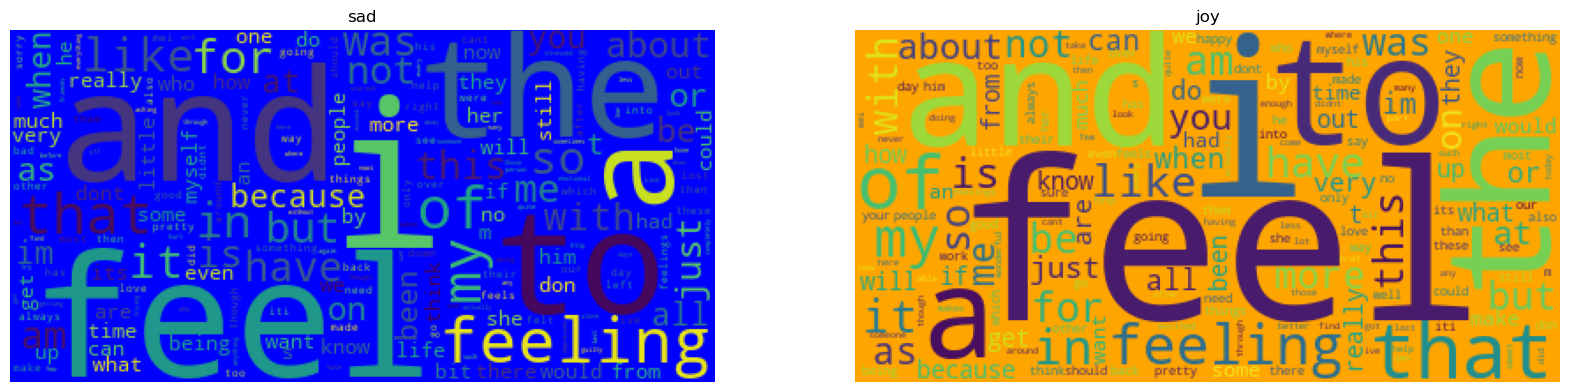

In [34]:
plt.figure(figsize= (20 , 30) ,facecolor='white')
plt.subplot(1, 2 ,1)
draw_wordcloud(sadness_freq , "sad" , "blue")


plt.subplot(1 , 2 , 2)
draw_wordcloud(joy_freq , "joy" , "orange")

plt.show()

# Baseline Model- Using Sklearn

In [35]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Initialize DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

In [37]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [38]:
y_pred = dummy_clf.predict(X_test)

# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.15784493794178214
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2980
           1       0.00      0.00      0.00      2961
           2       0.00      0.00      0.00      3115
           3       0.00      0.00      0.00      2981
           4       0.00      0.00      0.00      3094
           5       0.16      1.00      0.27      2836

    accuracy                           0.16     17967
   macro avg       0.03      0.17      0.05     17967
weighted avg       0.02      0.16      0.04     17967



C:\Users\mayan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mayan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mayan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Our own Dummy

In [39]:
# Define the model as a subclass of nn.Module
class DummyModel(nn.Module):
    def __init__(self, most_frequent_class):
        super(DummyModel, self).__init__()
        # Initialize parameter for guessing
        self.most_frequent_class = most_frequent_class

    def forward(self, x):
        # Return the most frequent class for all samples
        batch_size = x.shape[0]
        return torch.full((batch_size,), self.most_frequent_class, dtype=torch.int32)

In [40]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [41]:
my_dummy = DummyModel(most_frequent_class = 1)

# Forward pass
y_pred = my_dummy(X_test)
print(y_pred)  # Outputs: tensor([1, 1, 1, 1, 1])

tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)


In [42]:
# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.33884743648185023
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     24504
           1       0.34      1.00      0.51     28247
           2       0.00      0.00      0.00      6853
           3       0.00      0.00      0.00     11339
           4       0.00      0.00      0.00      9376
           5       0.00      0.00      0.00      3043

    accuracy                           0.34     83362
   macro avg       0.06      0.17      0.08     83362
weighted avg       0.11      0.34      0.17     83362



C:\Users\mayan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mayan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mayan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Our Softmax model

In [43]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class BOWRegressionModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(BOWRegressionModel, self).__init__()
        # Initialize linear layer
        self.linear = nn.Linear(num_feats, num_classes)  # Linear layer: Wx + b

    def forward(self, x):
        return  self.linear(x)  # Apply the linear transformation

In [44]:
#SVD- like PCA but works on Compressed Sparse Row format
num_features = 50
svd = TruncatedSVD(n_components = num_features)
X_svd = svd.fit_transform(X)
X_svd

array([[ 8.99043933e-01, -1.39683255e-01, -3.56852798e-01, ...,
        -1.01183200e-01, -1.87957069e-01,  7.65617184e-02],
       [ 2.45045645e+00, -1.61408122e+00, -3.18520078e-01, ...,
         7.75406789e-01,  4.41752989e-01, -2.45243792e-01],
       [ 8.63990092e-01, -4.06433613e-01,  5.92687733e-01, ...,
         5.63838651e-02,  1.40576159e-01, -1.01022991e-03],
       ...,
       [ 3.27212622e+00, -5.98559853e-02, -4.38271243e-01, ...,
         3.82717204e-01, -2.76927123e-01,  1.47922899e-01],
       [ 4.83879237e+00,  1.38409096e+00,  9.31564420e-01, ...,
         1.56299605e-02,  2.51258916e-01, -2.59354148e-02],
       [ 9.15086968e-01, -7.32439135e-02,  2.46781294e-01, ...,
         2.38799472e-01,  5.08451295e-01, -5.20783193e-02]])

In [45]:
X_svd.shape

(89832, 50)

In [46]:
y.shape

(89832,)

In [47]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_svd, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [48]:
#model = BOWRegressionModel(num_words = unique_words)
model = BOWRegressionModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Mean Squared Error for regression, Cross Entropy for multiclass
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
epochs = 300
for epoch in range(epochs):
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 10/300, Loss: 1.7809
Epoch 20/300, Loss: 1.7529
Epoch 30/300, Loss: 1.7774
Epoch 40/300, Loss: 1.7779
Epoch 50/300, Loss: 1.6990
Epoch 60/300, Loss: 1.7649
Epoch 70/300, Loss: 1.7670
Epoch 80/300, Loss: 1.6714
Epoch 90/300, Loss: 1.7902
Epoch 100/300, Loss: 1.7103
Epoch 110/300, Loss: 1.7008
Epoch 120/300, Loss: 1.7706
Epoch 130/300, Loss: 1.8635
Epoch 140/300, Loss: 1.6737
Epoch 150/300, Loss: 1.7598
Epoch 160/300, Loss: 1.7878
Epoch 170/300, Loss: 1.7599
Epoch 180/300, Loss: 1.7872
Epoch 190/300, Loss: 1.7263
Epoch 200/300, Loss: 1.7409
Epoch 210/300, Loss: 1.7861
Epoch 220/300, Loss: 1.8028
Epoch 230/300, Loss: 1.6711
Epoch 240/300, Loss: 1.7077
Epoch 250/300, Loss: 1.7690
Epoch 260/300, Loss: 1.6965
Epoch 270/300, Loss: 1.7475
Epoch 280/300, Loss: 1.7804
Epoch 290/300, Loss: 1.7692
Epoch 300/300, Loss: 1.7360


In [49]:
# Prediction: pick the class with the highest logits
def predict(model, X_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        logits = model(X_test_tensor)  # Get logits
        #probabilities = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_classes = torch.argmax(logits, dim=1)  # Choose class with the highest probability
    return predicted_classes

# Example: predicting on test data
y_pred = predict(model, X_test_tensor)

In [50]:
# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Accuracy:", accuracy(y_pred, y_test_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_test_tensor.long().view(-1)))

Accuracy: 0.24928948283195496
Confusion Matrix:
 tensor([[759, 448, 472, 330, 548, 423],
        [513, 758, 589, 283, 423, 395],
        [502, 611, 927, 254, 429, 392],
        [607, 399, 443, 497, 540, 495],
        [579, 444, 415, 336, 830, 490],
        [467, 423, 397, 289, 544, 716]])


In [52]:
'''
cm_np = confusion_matrix.numpy()

# Define class labels
class_labels = ["Sadness", "Joy", "Love", "Anger", "Fear", "Surprise"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_np, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add labels
tick_marks = range(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add text annotations
thresh = cm_np.max().item() / 2.0
for i in range(cm_np.size(0)):
    for j in range(cm_np.size(1)):
        plt.text(j, i, f"{cm_np[i, j].item()}", 
                 horizontalalignment="center",
                 color="white" if cm_np[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
'''

'\ncm_np = confusion_matrix.numpy()\n\n# Define class labels\nclass_labels = ["Sadness", "Joy", "Love", "Anger", "Fear", "Surprise"]\n\n# Plot confusion matrix\nplt.figure(figsize=(8, 6))\nplt.imshow(cm_np, interpolation="nearest", cmap=plt.cm.Blues)\nplt.title("Confusion Matrix")\nplt.colorbar()\n\n# Add labels\ntick_marks = range(len(class_labels))\nplt.xticks(tick_marks, class_labels, rotation=45)\nplt.yticks(tick_marks, class_labels)\n\n# Add text annotations\nthresh = cm_np.max().item() / 2.0\nfor i in range(cm_np.size(0)):\n    for j in range(cm_np.size(1)):\n        plt.text(j, i, f"{cm_np[i, j].item()}", \n                 horizontalalignment="center",\n                 color="white" if cm_np[i, j] > thresh else "black")\n\nplt.ylabel("True Label")\nplt.xlabel("Predicted Label")\nplt.tight_layout()\nplt.show()\n'

In [54]:
'''
def process(tweets):
    my_tweets = [word_tokenize(tweet.lower()) for tweet in tweets]
    all_tokens = [token for tweet in my_tweets for token in tweet]
    vocab = {word: idx + 1 for idx, word in enumerate(Counter(all_tokens))}
    vocab["<UNK>"] = 0  # Unknown token
    # Convert text to sequences
    encoded_tweets = [torch.tensor([vocab.get(token, 0) for token in tweet]) for tweet in my_tweets]
       
    padding_value = 
    
    # Pad sequences to the same length
    max_len = max(len(tweet) for tweet in encoded_tweets)  # Default to longest sequence length
    padded_tweets = torch.stack([
        torch.cat([tweet, torch.tensor([padding_value] * (max_len - len(tweet)))]) if len(tweet) < max_len else tweet[:max_len]
        for tweet in encoded_tweets
    ])
    
    return padded_tweets

processed_tweets = process(balanced_df["text"])
print(processed_tweets[0])
print(processed_tweets[1])
print(processed_tweets[2])
'''

'\ndef process(tweets):\n    my_tweets = [word_tokenize(tweet.lower()) for tweet in tweets]\n    all_tokens = [token for tweet in my_tweets for token in tweet]\n    vocab = {word: idx + 1 for idx, word in enumerate(Counter(all_tokens))}\n    vocab["<UNK>"] = 0  # Unknown token\n    # Convert text to sequences\n    encoded_tweets = [torch.tensor([vocab.get(token, 0) for token in tweet]) for tweet in my_tweets]\n       \n    padding_value = \n    \n    # Pad sequences to the same length\n    max_len = max(len(tweet) for tweet in encoded_tweets)  # Default to longest sequence length\n    padded_tweets = torch.stack([\n        torch.cat([tweet, torch.tensor([padding_value] * (max_len - len(tweet)))]) if len(tweet) < max_len else tweet[:max_len]\n        for tweet in encoded_tweets\n    ])\n    \n    return padded_tweets\n\nprocessed_tweets = process(balanced_df["text"])\nprint(processed_tweets[0])\nprint(processed_tweets[1])\nprint(processed_tweets[2])\n'

In [57]:
#print(processed_tweets.shape)  # (num_samples, max_len)

# Fully Connected Neural Network

In [58]:
# Define the model as a subclass of nn.Module for a bag-of-words pre-processing
class FullyConnectedModel(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(FullyConnectedModel, self).__init__()
        # Initialize linear layer
        self.hidden1 = nn.Linear(num_feats, 100)  # Linear layer: Wx + b with 100 neurons
        self.hidden2 = nn.Linear(100, 60)  # Linear layer: Wx + b with 60 neurons
        self.out = nn.Linear(60, num_classes)  # Linear layer: Wx + b with 6 neurons

    def forward(self, x):
        x = torch.relu(self.hidden1(x)) # Apply hidden layer 1
        x = torch.relu(self.hidden2(x)) # Apply hidden layer 2
        return  self.out(x)  # Apply last layer to get output for each class

In [59]:
#model = BOWRegressionModel(num_words = unique_words)
model = FullyConnectedModel(num_features, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Cross Entropy for multiclass
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
epochs = 100
for epoch in range(epochs):
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 10/100, Loss: 1.7575
Epoch 20/100, Loss: 1.7560
Epoch 30/100, Loss: 1.7407
Epoch 40/100, Loss: 1.7676
Epoch 50/100, Loss: 1.7008
Epoch 60/100, Loss: 1.6879
Epoch 70/100, Loss: 1.7467
Epoch 80/100, Loss: 1.7300
Epoch 90/100, Loss: 1.6863
Epoch 100/100, Loss: 1.6984


In [60]:
# Example: predicting on test data
y_pred = predict(model, X_test_tensor)

# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Accuracy:", accuracy(y_pred, y_test_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_test_tensor.long().view(-1)))

Accuracy: 0.2550511658191681
Confusion Matrix:
 tensor([[685, 485, 478, 416, 451, 465],
        [431, 780, 595, 341, 368, 446],
        [420, 701, 970, 303, 327, 394],
        [539, 424, 416, 600, 493, 509],
        [501, 474, 417, 427, 731, 544],
        [405, 450, 367, 328, 469, 817]])


# Word embedding- Word2Vec

In [64]:
# Tokenize sentences into words
sentences = balanced_df['text'].apply(lambda x: x.split())

# Train a Word2Vec model on your dataset
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Function to compute the average Word2Vec vector for a sentence
def sentence_to_vector(sentence, model, vector_size):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)  # Return a zero vector for empty or OOV sentences

In [67]:
vector_size = word2vec_model.vector_size
X = np.array(balanced_df['text'].apply(lambda x: sentence_to_vector(x, word2vec_model, vector_size)).tolist())

In [68]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)  # Reshape labels for PyTorch

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [69]:
#model = BOWRegressionModel(num_words = unique_words)
model = FullyConnectedModel(vector_size, 6)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Loss function: Cross Entropy for multiclass
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
epochs = 100
for epoch in range(epochs):
    for batch_X, batch_y in loader:
        # Ensure target labels are in the correct format (long tensor of class indices)
        batch_y = batch_y.long().view(-1)  # Ensure batch_y is of type long (required for CrossEntropyLoss)
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 10/100, Loss: 1.5354
Epoch 20/100, Loss: 1.3834
Epoch 30/100, Loss: 1.3409
Epoch 40/100, Loss: 1.3863
Epoch 50/100, Loss: 1.1466
Epoch 60/100, Loss: 1.2817
Epoch 70/100, Loss: 1.0846
Epoch 80/100, Loss: 1.2464
Epoch 90/100, Loss: 0.9943
Epoch 100/100, Loss: 1.2568


In [70]:
# Example: predicting on test data
y_pred = predict(model, X_test_tensor)

# Accuracy metric
accuracy = MulticlassAccuracy(num_classes=6)
print("Accuracy:", accuracy(y_pred, y_test_tensor.long().view(-1)).item())

# Confusion matrix
confusion_matrix = MulticlassConfusionMatrix(num_classes=6)
print("Confusion Matrix:\n", confusion_matrix(y_pred, y_test_tensor.long().view(-1)))

Accuracy: 0.508057713508606
Confusion Matrix:
 tensor([[ 895,  723,  486,  565,  199,  112],
        [ 365, 1489,  628,  243,  105,  131],
        [  74,  306, 2058,  263,  141,  273],
        [ 236,  309,  588, 1187,  400,  261],
        [ 213,  184,  474,  615,  944,  664],
        [  12,   38,  149,   64,   74, 2499]])
